# Logistic Regression Model
## Model 1

# Imports 

In [39]:
# Imports
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,person_education,Combined Master and Doctorate categories into one group -- Graduate,Doctorate had the lowest frequency out of all the categories which could impact analysis
6,person_home_ownership,Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category,RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis
7,"['person_gender', 'loan_intent', 'previous_loan_defaults_on_file', 'person_education_new', 'person_home_ownership_new']",Applied one-hot encoding (drop_first=True),Converted categorical variables into binary indicators for model compatibility.
8,loan_status,Readded loan_status column,Target variable for classification; readded after cleaning and preprocessing.


# Data Prep

In [4]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

,person_age,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,log_income,log_loan_amt,person_gender_male,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,person_education_new_Bachelor,person_education_new_Graduate,person_education_new_High School,person_home_ownership_new_Non-Homeowner,loan_status
0,22,0,16.02,0.49,3,561,11.183713,10.463132,0,0,0,0,1,0,0,0,1,0,1,1
1,21,0,11.14,0.08,2,504,9.415971,6.908755,0,1,0,0,0,0,1,0,0,1,0,0
2,25,3,12.87,0.44,3,635,9.428592,8.612685,0,0,0,1,0,0,0,0,0,1,0,1
3,23,0,15.23,0.44,2,675,11.286702,10.463132,0,0,0,1,0,0,0,1,0,0,1,1
4,24,1,14.27,0.53,4,586,11.099469,10.463132,1,0,0,1,0,0,0,0,1,0,1,1


In [5]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (31494, 19)
X_test: (13498, 19)


In [7]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Check for class imbalance
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set:\n{y_test.value_counts(normalize=True)}")

# Changelog addition
changelog.append({
    'column': 'numerical_columns',
    'change': 'Applied MinMaxScaler to training data; transformed test data using same scaler.',
    'rationale': 'Avoided data leakage by fitting scaler only on training data. Ensures proper model generalization and adheres to machine learning best practices.'
})



Class distribution in training set:
loan_status
0    0.777799
1    0.222201
Name: proportion, dtype: float64
Class distribution in test set:
loan_status
0    0.777819
1    0.222181
Name: proportion, dtype: float64


# Models


In [20]:
# Logistic Regression
lrBase = LogisticRegression(max_iter=1000, solver='saga')
lrBase.fit(X_train_scaled, y_train)
y_pred = lrBase.predict(X_test_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.8069343606460216
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.98      0.89     10499
           1       0.73      0.21      0.33      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.59      0.61     13498
weighted avg       0.79      0.81      0.76     13498



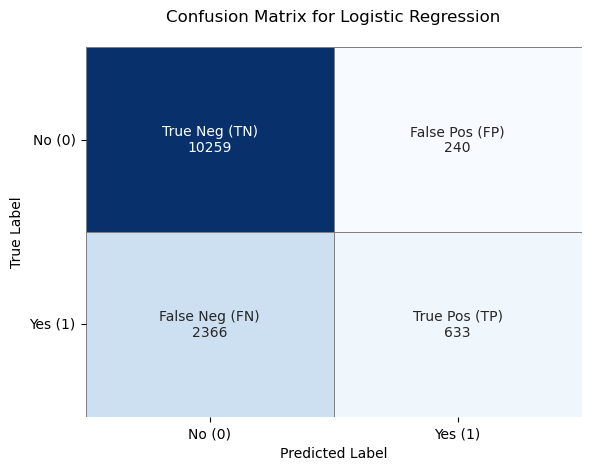

In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Annotations for squares
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = [f'{value}' for value in cm.flatten()]
labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

# Plot
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression\n')
plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
plt.show()

In [22]:
#Evaluate the model
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred)))

tn = cm[0,0]
fp = cm[0,1]
specificity = tn/(tn+fp)
print('Specificity Score: {:.2f}'.format(specificity))

Accuracy Score: 0.81
Precision Score: 0.73
Recall Score: 0.21
Specificity Score: 0.98


In [11]:
# SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after SMOTE
X_smote_test = X_test_scaled
y_smote_test = y_test

# Changelog entry for SMOTE
changelog.append({
    'column': 'subscribe_to_term_deposit',
    'change': f'Resampled training set with SMOTE (train shape now: {X_smote_train.shape}, test shape: {X_test.shape})',
    'rationale': 'Used SMOTE to correct class imbalance in training data for better model performance.'
})


In [ ]:
# Train/test split on SMOTE
#X_smote = df.drop(columns=['loan_status'])
#y_smote = df['loan_status']

#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
#smote = SMOTE(random_state=42)
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_smote_train, y_smote_train)
y_smote_pred = lr_smote.predict(X_test_scaled)




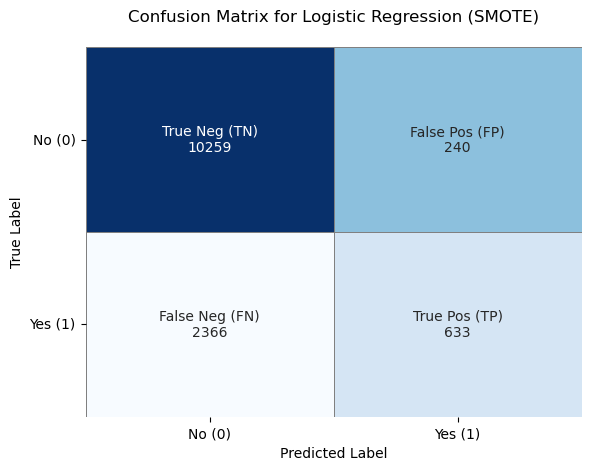

Accuracy Score: 0.67
Precision Score: 0.37
Recall Score: 0.68
Specificity Score: 0.67


In [28]:
# Compute confusion matrix
cm_smote = confusion_matrix(y_test, y_smote_pred)

# Define labels for annotations
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = [f'{value}' for value in cm.flatten()]
labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

# Plot
sns.heatmap(cm_smote, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression (SMOTE)\n')
plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
plt.show()

#Evaluate the model
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_smote_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_smote_pred)))
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_smote_pred)))

tn_smote = cm_smote[0,0]
fp_smote = cm_smote[0,1]
specificity_smote = tn_smote/(tn_smote+fp_smote)
print('Specificity Score: {:.2f}'.format(specificity_smote))

<h3> Cross-Validation </h3>

In [50]:
# Cross-validation on the original data
#Create the model
lr_CV = LogisticRegression(max_iter=1000)

#Set the number of splits
k_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Create pipeline to scale and run the model
pipeline = Pipeline([('scaler', scaler), ('model',lr_CV)])

#Run the cross-validation and evaluate the model
cv_scores = cross_val_score(pipeline, X, y, cv=k_folds, scoring='recall')
print("Cross-validation scores:", cv_scores)
print("Mean CV Recall:", cv_scores.mean())

Cross-validation scores: [0.212      0.2025     0.2086043  0.23111556 0.21910955]
Mean CV Recall: 0.2146658829414707


In [53]:
# Cross-validation with SMOTE
#Create the model
lr_CV_smote = LogisticRegression(max_iter=1000, random_state=42, C=2.782559402207126)

#Set the number of splits
k_folds_smote = KFold(n_splits=5, shuffle=True, random_state=42)

#Create pipeline to scale and run the model
pipeline_smote = ImbPipeline([('scaler', scaler), ('smote', smote), ('model',lr_CV)])

#Run the cross-validation and evaluate the model
cv_scores_smote = cross_val_score(pipeline_smote, X, y, cv=k_folds_smote, scoring='recall')
print("Cross-validation scores:", cv_scores_smote)
print("Mean CV Recall:", cv_scores_smote.mean())

Cross-validation scores: [0.67018072 0.66650509 0.67031873 0.68139774 0.67152918]
Mean CV Recall: 0.6719862903336792


In [ ]:
#Scores for Original data
lr_cv_scores = cross_val_score(LogisticRegression(random_state=42, solver='liblinear'),
                                X_train_scaled, y_train, cv=5, scoring='recall')

#Scores for SMOTE data
lr_smote_cv_scores = cross_val_score(lr_smote, X_smote_train, y_smote_train, cv=5, scoring='recall')

print("\nLogistic Regression Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV Recall':<20}")
print(f"{'Original':<20}{lr_cv_scores.mean():<20.4f}")
print(f"{'SMOTE':<20}{lr_smote_cv_scores.mean():<20.4f}")


<h3> Hyperparameter Tuning </h3>

<h4> Original Data </h4>

In [ ]:
# Logistic Regression Hyperparameter Tuning
lr_param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid, cv=5, scoring='recall', n_jobs=-1)
lr_grid_search.fit(X_train_scaled, y_train)

print("\nLogistic Regression Best Parameters:", lr_grid_search.best_params_)
lr_best_model = lr_grid_search.best_estimator_


Logistic Regression Best Parameters: {'C': 2.782559402207126, 'penalty': 'l1', 'solver': 'liblinear'}



Logistic Regression (Tuned):
              precision    recall  f1-score   support

    Rejected       0.81      0.98      0.89     10499
    Approved       0.72      0.21      0.33      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.59      0.61     13498
weighted avg       0.79      0.81      0.76     13498



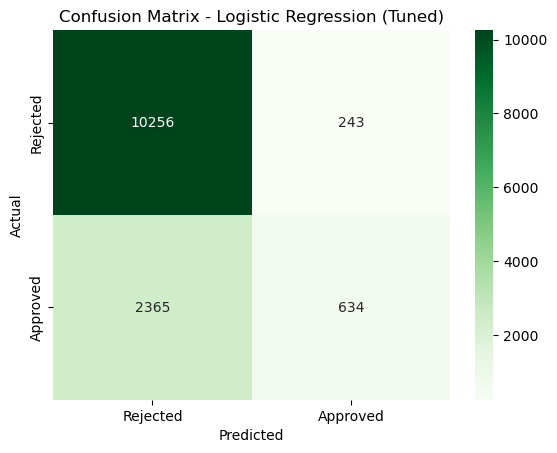

Accuracy Score: 0.81
Precision Score: 0.72
Recall Score: 0.21


In [63]:
# Define string labels for display
target_names = ['Rejected', 'Approved'] 

# Generate predictions
lr_tuned_predictions = lr_best_model.predict(X_test_scaled)

# Classification report
print("\nLogistic Regression (Tuned):")
print(classification_report(y_test, lr_tuned_predictions, target_names=target_names))

# Confusion matrix
cm_lr_tuned = confusion_matrix(y_test, lr_tuned_predictions, labels=[0, 1])
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (Tuned)')
plt.show()

#Evaluate the model
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, lr_tuned_predictions)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, lr_tuned_predictions)))
print('Recall Score: {:.2f}'.format(recall_score(y_test, lr_tuned_predictions)))


<h4> Data with Smote </h4>

In [66]:
# SMOTE Logistic Regression Hyperparameter Tuning
lr_param_grid_smote = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid_search_smote = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid_smote, cv=5, scoring='recall', n_jobs=-1)
lr_grid_search_smote.fit(X_smote_train, y_smote_train)

print("\nLogistic Regression Best Parameters:", lr_grid_search_smote.best_params_)
lr_best_model_smote = lr_grid_search.best_estimator_


Logistic Regression Best Parameters: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}



Logistic Regression (Tuned):
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     10499
           1       0.72      0.21      0.33      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.59      0.61     13498
weighted avg       0.79      0.81      0.76     13498



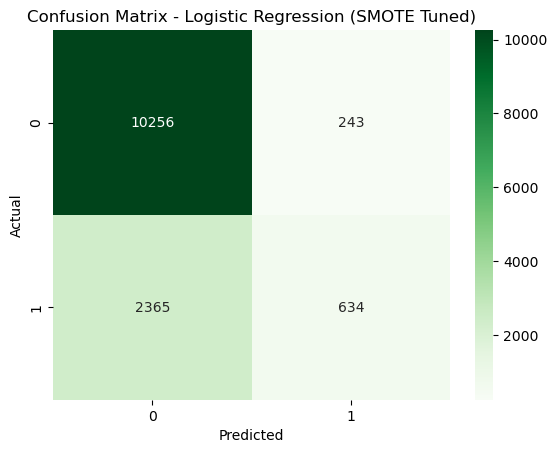

Accuracy Score: 0.81
Precision Score: 0.72
Recall Score: 0.21


In [67]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
lr_tuned_predictions_smote = lr_best_model_smote.predict(X_test_scaled)

# Classification report
print("\nLogistic Regression (Tuned):")
print(classification_report(y_test, lr_tuned_predictions_smote, target_names=target_names))

# Confusion matrix
cm_lr_tuned_smote = confusion_matrix(y_test, lr_tuned_predictions_smote, labels=[0, 1])
sns.heatmap(cm_lr_tuned_smote, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (SMOTE Tuned)')
plt.show()

#Evaluate the model
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, lr_tuned_predictions_smote)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, lr_tuned_predictions_smote)))
print('Recall Score: {:.2f}'.format(recall_score(y_test, lr_tuned_predictions_smote)))


In [69]:
print("Original:", cm_lr_tuned)
print("Smote:", cm_lr_tuned_smote)

Original: [[10256   243]
 [ 2365   634]]
Smote: [[10256   243]
 [ 2365   634]]


In [ ]:
# --- Learning Curve ---

print("\n--- Learning Curve ---")

def plot_learning_curve(estimator, title, X, y, axes=None, train_sizes=np.linspace(0.1, 1.0, 5), cv=None, scoring='accuracy'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.legend(loc="best")
    return plt

# Plot learning curves for different models
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
# Original
plot_learning_curve(LogisticRegression(random_state=42), 
                    "Logistic Regression (Base)", 
                    X_train, y_train, axes=axes[0], cv=5)

# SMOTE
plot_learning_curve(LogisticRegression(random_state=42), 
                    "Logistic Regression (SMOTE)", 
                    X_smote_train, y_smote_train, axes=axes[1], cv=5)

# Tuned model
plot_learning_curve(lr_best_model, 
                    "Logistic Regression (Tuned)", 
                    X_train, y_train, axes=axes[2], cv=5)

plt.tight_layout()
plt.show()



In [ ]:
# --- Hyperparameter Tuning using Grid Search CV ---

print("\n--- Hyperparameter Tuning using Grid Search CV ---")

# Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

print("\nDecision Tree Best Parameters:", dt_grid_search.best_params_)
dt_best_model = dt_grid_search.best_estimator_


In [ ]:
# Visualize the Decision Tree
plt.figure(figsize=(25, 10))
plot_tree(dt_best_model, feature_names=X_train.columns, class_names=['Rejected', 'Approved'], filled=True, fontsize=8,
          impurity=False,       
          proportion=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.tight_layout()
plt.show()